<h2>IMPORT LIBRARIES</h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import shap
from sklearn.metrics import r2_score, mean_squared_error
import itertools
import functools
import re

d:\FCIS\Machine Learning\Project\Environ\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.stats import zscore
import pywt
from scipy.stats import pointbiserialr,f_oneway
import copy


<h3>UTILS</h3>

In [3]:
def anova_test(df, categorical_columns, target_column):
    
    p_values = {}  
    
    for categorical_column in categorical_columns:
        categories = df[categorical_column].unique()
        
        data = []
        
        for category in categories:
            data.append(df[df[categorical_column] == category][target_column])
        
        statistic, p_value = f_oneway(*data)
        
        p_values[categorical_column] = p_value
    
    return p_values

In [4]:
def filter_categorial(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    categorical_df = df[categorical_columns]

    return categorical_df

In [5]:
def filter_numerical(df):
    numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns
    numerical_df = df[numerical_columns]

    return numerical_df

In [6]:
def transform_ordinal_means(df,column,target):  
    return df.groupby(column)[target].transform("mean")

In [7]:
def transform_ordinal(df,column,target):
    sub_dict=df.groupby(column)[target].mean().sort_values()
    sub_dict={k:v for v,k in enumerate(sub_dict.keys())}
    return sub_dict     #df[new_col]=df[column].map(transform_ordinal(df,column,target_col"Profit")) To apply mapping on the dataframe in a new column

In [8]:
def feature_select_numerical(df,target_col):
    
    corr=filter_numerical(df).corr().round(2)
    final_df=pd.DataFrame()
    for column in corr.columns:
        if(abs(corr[column][target_col])>=0.05):
            final_df[column]=df[column]
    return final_df

In [9]:
def one_hot_encode_columns(columns_list, df):
    
    encoded_df = pd.DataFrame()

    for col in columns_list:
        encoded_cols = pd.get_dummies(df[col], prefix=col, prefix_sep='_',dtype=int)
        encoded_df = pd.concat([encoded_df, encoded_cols], axis=1)

    return encoded_df

In [10]:
def normalize_feature(df):
    copy_df=copy.deepcopy(df)
    scaler=MinMaxScaler()
    scaler.fit(copy_df)
    return pd.DataFrame(scaler.transform(copy_df),columns=df.columns)

<h3>Data Reading</h3>

In [11]:
data = pd.read_csv('megastore-regression-dataset.csv')

In [12]:

data['Order Date']=pd.to_datetime(data['Order Date'])
data['Order year']=data['Order Date'].dt.year
data['Order quarter']=data['Order Date'].dt.quarter
data = data.drop('Order Date', axis=1)

data['Ship Date']=pd.to_datetime(data['Ship Date'])
data['Ship year']=data['Ship Date'].dt.year
data['Ship quarter']=data['Ship Date'].dt.quarter
data = data.drop('Ship Date', axis=1)

<h3>Convert CategoryTree to Main Category and Sub Category Features</h3>

In [13]:
data[["Main Category","Sub Category"]]=data["CategoryTree"].str.extract("'MainCategory': '(?P<Main_Category>[^']*)', 'SubCategory': '(?P<Sub_Category>[^']*)'")

In [14]:
data.drop(columns=['CategoryTree'],inplace=True)

In [15]:
data.columns

Index(['Row ID', 'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name',
       'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
       'Product ID', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Order year', 'Order quarter', 'Ship year', 'Ship quarter',
       'Main Category', 'Sub Category'],
      dtype='object')

<h3>Searching for nulls</h3>

In [16]:
data.isna().sum()       #No nulls in the data

Row ID           0
Order ID         0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
Order year       0
Order quarter    0
Ship year        0
Ship quarter     0
Main Category    0
Sub Category     0
dtype: int64

<h3>Outliers Searching</h3>

In [17]:
z_scores = zscore(data['Profit'])

# Identify potential outliers based on z-scores
outliers = data[abs(z_scores) > 3]  # Using a threshold of 3 for z-scores
print(outliers['Profit'])

56       682.5168
75     -2639.9912
117    -1141.4700
125     2239.9872
171      700.9800
          ...    
7636    3177.4750
7682     757.4112
7722    4630.4755
7741    1119.9968
7764    1270.9900
Name: Profit, Length: 94, dtype: float64


<h2>General Analysis</h2>

(array([ 0.,  1.,  0.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
         1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
         2.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,  1.,
         0.,  0.,  1.,  3.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,  0.,  0.,  2.,  2.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  2.

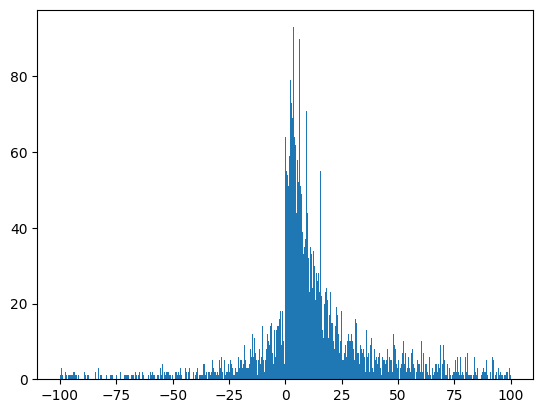

In [18]:
plt.hist(data["Profit"],range=(-100,100),bins=1000)

Text(0, 0.5, 'Mean Profit')

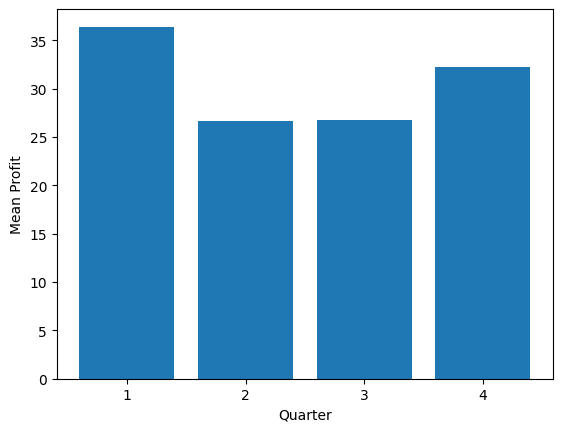

In [19]:
plt.bar(data.groupby('Order quarter')['Profit'].mean().to_dict().keys(),data.groupby('Order quarter')['Profit'].mean().to_dict().values())
plt.xticks([1,2,3,4],data["Order quarter"].unique().sort())
plt.xlabel("Quarter")
plt.ylabel("Mean Profit")

<h3>Create Another Column "Mean profit for each state" and "Mean profit for each customer" (Customer_loyalty)</h3>

In [18]:
mapping_dict=data.groupby("State")["Profit"].mean().to_dict()
data['state_mean'] = data['State'].map(mapping_dict)

In [19]:
data[['state_mean','State']]            #Same as Transform_ordinal_means function

,state_mean,State
0,66.225242,New York
1,62.855090,Indiana
2,37.685365,California
3,68.536951,Virginia
4,-26.915380,Texas
...,...,...
7990,-24.956068,Ohio
7991,37.685365,California
7992,66.225242,New York
7993,37.685365,California


In [20]:
data["state_mean"].corr(data["Profit"])     #Gets 21% Correlation With the target variable


0.21440769026938017

In [21]:
data.drop(columns=["Row ID","Order ID","Customer ID","City","Postal Code","Ship year","Ship quarter","Product Name"],inplace=True)

In [22]:
data["customer_loyalty"]=data.groupby("Customer Name")["Profit"].transform("mean")

In [23]:
data["customer_loyalty"].corr(data["Profit"])   #High Correlation between customer loyalty and profit

0.3293185171329078

In [24]:
data["Sales"].corr(data["Profit"])

0.5715250812257774

In [25]:
data.columns

Index(['Ship Mode', 'Customer Name', 'Segment', 'Country', 'State', 'Region',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit', 'Order year',
       'Order quarter', 'Main Category', 'Sub Category', 'state_mean',
       'customer_loyalty'],
      dtype='object')

In [26]:
data["Order year"].corr(data["Profit"])     #Order year has a bad correlation , To be Dropped

0.012600317679478052

In [27]:
ship_map=data.groupby("Ship Mode")["Profit"].mean().sort_values()
ship_map

Ship Mode
Same Day          24.580392
Second Class      27.360317
Standard Class    29.375327
First Class       38.695110
Name: Profit, dtype: float64

In [28]:
ship_map={k:v for v,k in enumerate(ship_map.keys())} 
ship_map

{'Same Day': 0, 'Second Class': 1, 'Standard Class': 2, 'First Class': 3}

In [29]:
data['ship_priority'] = data['Ship Mode'].map(ship_map) # same as Transform_ordinal function

In [30]:
data[["ship_priority","Profit","Ship Mode"]]

,ship_priority,Profit,Ship Mode
0,0,5.9970,Same Day
1,2,60.4224,Standard Class
2,2,4.6488,Standard Class
3,2,15.5520,Standard Class
4,2,-15.5904,Standard Class
...,...,...,...
7990,3,2.9145,First Class
7991,3,12.2247,First Class
7992,2,6.0030,Standard Class
7993,2,21.5964,Standard Class


In [31]:
data["ship_priority"].corr(data["Profit"])      #Ship priority has Bad correlation, To be Dropped

0.015395039276256964

In [32]:
sub_cat_dict=data.groupby("Sub Category")["Profit"].mean().sort_values()
sub_cat_dict={k:v for v,k in enumerate(sub_cat_dict.keys())}
sub_cat_dict

{'Tables': 0,
 'Bookcases': 1,
 'Supplies': 2,
 'Fasteners': 3,
 'Art': 4,
 'Furnishings': 5,
 'Labels': 6,
 'Paper': 7,
 'Envelopes': 8,
 'Storage': 9,
 'Binders': 10,
 'Appliances': 11,
 'Chairs': 12,
 'Phones': 13,
 'Accessories': 14,
 'Machines': 15,
 'Copiers': 16}

In [33]:
data["sub_cat_encoded"]=data["Sub Category"].map(sub_cat_dict)
data["sub_cat_encoded"].corr(data["Profit"])

0.13655603382651996

In [34]:
anova_test(data,["State","Segment","Customer Name","Region","Order quarter","Main Category","Sub Category","Product ID"],"Profit")

{'State': 3.0788218592530043e-52,
 'Segment': 0.16303478233943347,
 'Customer Name': 0.022875415355986837,
 'Region': 0.008360591767109989,
 'Order quarter': 0.5262944043748036,
 'Main Category': 3.0370642607455033e-21,
 'Sub Category': 8.083173426152449e-147,
 'Product ID': 0.0}

<h3>Drop HIGH P-values Data</h3>

In [35]:
data.drop(columns=["Country","Segment"],inplace=True)

In [36]:
data.columns

Index(['Ship Mode', 'Customer Name', 'State', 'Region', 'Product ID', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Order year', 'Order quarter',
       'Main Category', 'Sub Category', 'state_mean', 'customer_loyalty',
       'ship_priority', 'sub_cat_encoded'],
      dtype='object')

In [37]:
filter_numerical(data.drop(columns=["Order year","Order quarter"]))

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,ship_priority,sub_cat_encoded
0,119.940,6,0.0,5.9970,66.225242,-2.023000,0,13
1,125.880,6,0.0,60.4224,62.855090,35.348275,2,10
2,14.304,6,0.2,4.6488,37.685365,9.258253,2,10
3,32.400,5,0.0,15.5520,68.536951,4.654125,2,7
4,77.952,3,0.2,-15.5904,-26.915380,17.475229,2,9
...,...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,-24.956068,-122.522389,3,3
7991,26.010,9,0.0,12.2247,37.685365,37.428837,3,6
7992,13.050,5,0.0,6.0030,66.225242,-1.279672,2,6
7993,59.990,7,0.0,21.5964,37.685365,4.916386,2,5


<Axes: >

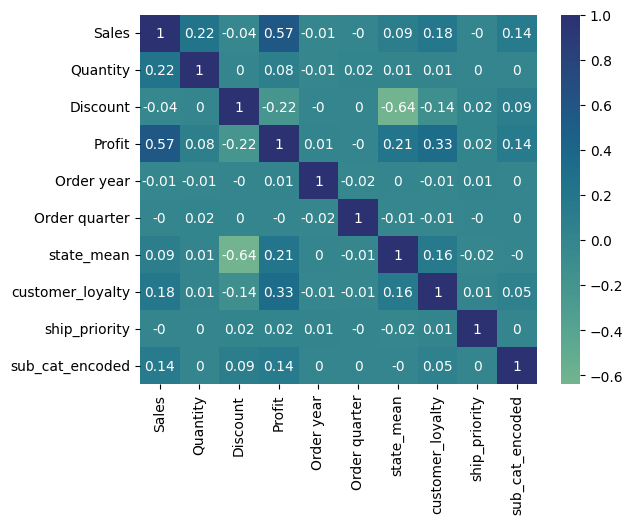

In [157]:
sns.heatmap(filter_numerical(data).corr().round(2), annot=True, cmap='crest', center=0)


In [38]:
corr=filter_numerical(data).corr().round(2)
corr.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'Order year',
       'Order quarter', 'state_mean', 'customer_loyalty', 'ship_priority',
       'sub_cat_encoded'],
      dtype='object')

In [39]:
final_df_num=feature_select_numerical(data,"Profit")

In [40]:
final_df_num

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded
0,119.940,6,0.0,5.9970,66.225242,-2.023000,13
1,125.880,6,0.0,60.4224,62.855090,35.348275,10
2,14.304,6,0.2,4.6488,37.685365,9.258253,10
3,32.400,5,0.0,15.5520,68.536951,4.654125,7
4,77.952,3,0.2,-15.5904,-26.915380,17.475229,9
...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,-24.956068,-122.522389,3
7991,26.010,9,0.0,12.2247,37.685365,37.428837,6
7992,13.050,5,0.0,6.0030,66.225242,-1.279672,6
7993,59.990,7,0.0,21.5964,37.685365,4.916386,5


In [41]:
filter_categorial(data)

,Ship Mode,Customer Name,State,Region,Product ID,Main Category,Sub Category
0,Same Day,Charlotte Melton,New York,East,TEC-PH-10002583,Technology,Phones
1,Standard Class,Patrick O'Donnell,Indiana,Central,OFF-BI-10001989,Office Supplies,Binders
2,Standard Class,Darrin Sayre,California,West,OFF-BI-10002609,Office Supplies,Binders
3,Standard Class,Mike Kennedy,Virginia,South,OFF-PA-10004983,Office Supplies,Paper
4,Standard Class,Lindsay Shagiari,Texas,Central,OFF-ST-10002583,Office Supplies,Storage
...,...,...,...,...,...,...,...
7990,First Class,Victoria Pisteka,Ohio,East,OFF-FA-10002988,Office Supplies,Fasteners
7991,First Class,Steven Cartwright,California,West,OFF-LA-10004689,Office Supplies,Labels
7992,Standard Class,Karl Braun,New York,East,OFF-LA-10000262,Office Supplies,Labels
7993,Standard Class,Christy Brittain,California,West,FUR-FU-10000719,Furniture,Furnishings


<h3>Another Encoding Method <b>try for every CATEGORICAL FEATURE in regression</b> </h3>

In [46]:
data["sub_cat_means"]=data.groupby("Sub Category")["Profit"].transform("mean")      #Sub category means (Same as transform_ordinal_means)
data["sub_cat_means"]

0       49.472034
1       28.607205
2       28.607205
3       24.131058
4       27.473830
          ...    
7990     4.460996
7991    15.893989
7992    15.893989
7993    12.628857
7994     8.085378
Name: sub_cat_means, Length: 7995, dtype: float64

In [47]:
data["sub_cat_means"].corr(data["Profit"])      
#GETS HIGH CORRELATION But i thik something is wrong by transforming each feature with its means (Try in regression)

0.29722364533606654

In [48]:
data.drop(columns=["sub_cat_means"],inplace=True)

<h3>Encode the lower P-values Columns with one-hot-encoding <b>try both one-hot and transform ordinal  </h3>

In [42]:
final_cat_df=one_hot_encode_columns(["Main Category","Region"],data)  #Categorical features

In [43]:
final_cat_df.dtypes

Main Category_Furniture          int32
Main Category_Office Supplies    int32
Main Category_Technology         int32
Region_Central                   int32
Region_East                      int32
Region_South                     int32
Region_West                      int32
dtype: object

In [44]:
final_df_num        #Numerical Values

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded
0,119.940,6,0.0,5.9970,66.225242,-2.023000,13
1,125.880,6,0.0,60.4224,62.855090,35.348275,10
2,14.304,6,0.2,4.6488,37.685365,9.258253,10
3,32.400,5,0.0,15.5520,68.536951,4.654125,7
4,77.952,3,0.2,-15.5904,-26.915380,17.475229,9
...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,-24.956068,-122.522389,3
7991,26.010,9,0.0,12.2247,37.685365,37.428837,6
7992,13.050,5,0.0,6.0030,66.225242,-1.279672,6
7993,59.990,7,0.0,21.5964,37.685365,4.916386,5


In [45]:
final_df=pd.concat([final_df_num,final_cat_df],axis=1)


In [46]:
final_df.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'state_mean',
       'customer_loyalty', 'sub_cat_encoded', 'Main Category_Furniture',
       'Main Category_Office Supplies', 'Main Category_Technology',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West'],
      dtype='object')

<h3>Explain Output of both feature-encoding functions</h3>

In [55]:
transform_ordinal_means(data,"State","Profit")

0       66.225242
1       62.855090
2       37.685365
3       68.536951
4      -26.915380
          ...    
7990   -24.956068
7991    37.685365
7992    66.225242
7993    37.685365
7994    66.225242
Name: Profit, Length: 7995, dtype: float64

In [55]:
transform_ordinal(data,"State","Profit")

{'Tennessee': 0,
 'North Carolina': 1,
 'Colorado': 2,
 'Texas': 3,
 'Ohio': 4,
 'Pennsylvania': 5,
 'Illinois': 6,
 'West Virginia': 7,
 'Arizona': 8,
 'Oregon': 9,
 'Florida': 10,
 'Kansas': 11,
 'South Dakota': 12,
 'New Mexico': 13,
 'North Dakota': 14,
 'South Carolina': 15,
 'California': 16,
 'Iowa': 17,
 'Utah': 18,
 'Idaho': 19,
 'Connecticut': 20,
 'New Hampshire': 21,
 'Massachusetts': 22,
 'Louisiana': 23,
 'Maine': 24,
 'Arkansas': 25,
 'Mississippi': 26,
 'Missouri': 27,
 'Indiana': 28,
 'Nebraska': 29,
 'New York': 30,
 'Wisconsin': 31,
 'Virginia': 32,
 'Maryland': 33,
 'Washington': 34,
 'Kentucky': 35,
 'New Jersey': 36,
 'Oklahoma': 37,
 'District of Columbia': 38,
 'Alabama': 39,
 'Wyoming': 40,
 'Nevada': 41,
 'Georgia': 42,
 'Michigan': 43,
 'Delaware': 44,
 'Minnesota': 45,
 'Rhode Island': 46,
 'Montana': 47,
 'Vermont': 48}

<h3>Turn dataframe into CSV</h3>

In [179]:
final_df.to_csv("best_features.csv",index=False)

In [194]:
final_df

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded,Main Category_Furniture,Main Category_Office Supplies,Main Category_Technology,Region_Central,Region_East,Region_South,Region_West
0,119.940,6,0.0,5.9970,66.225242,-2.023000,13,0,0,1,0,1,0,0
1,125.880,6,0.0,60.4224,62.855090,35.348275,10,0,1,0,1,0,0,0
2,14.304,6,0.2,4.6488,37.685365,9.258253,10,0,1,0,0,0,0,1
3,32.400,5,0.0,15.5520,68.536951,4.654125,7,0,1,0,0,0,1,0
4,77.952,3,0.2,-15.5904,-26.915380,17.475229,9,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,-24.956068,-122.522389,3,0,1,0,0,1,0,0
7991,26.010,9,0.0,12.2247,37.685365,37.428837,6,0,1,0,0,0,0,1
7992,13.050,5,0.0,6.0030,66.225242,-1.279672,6,0,1,0,0,1,0,0
7993,59.990,7,0.0,21.5964,37.685365,4.916386,5,1,0,0,0,0,0,1


In [47]:
final_df_norm=normalize_feature(final_df)
X_op1=final_df.drop(columns=["Profit"])
Y_op1=final_df["Profit"]

In [48]:
X_train1,X_test1,Y_train1,Y_test1=train_test_split(X_op1,Y_op1,test_size=0.2,random_state=42)

In [58]:
X_test1

,Sales,Quantity,Discount,state_mean,customer_loyalty,sub_cat_encoded,Main Category_Furniture,Main Category_Office Supplies,Main Category_Technology,Region_Central,Region_East,Region_South,Region_West
5487,5.640,3,0.0,100.241852,22.378300,10,0,1,0,0,0,1,0
2577,31.104,6,0.2,-24.956068,23.388259,7,0,1,0,0,1,0,0
3692,128.850,3,0.0,50.863920,-2.941147,13,0,0,1,0,1,0,0
5918,269.980,2,0.0,64.248610,36.447300,13,0,0,1,1,0,0,0
7562,115.360,7,0.0,82.080005,-34.777609,14,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,45.680,2,0.0,75.591956,16.419270,7,0,1,0,0,0,1,0
6573,2.610,1,0.0,108.775088,31.095184,6,0,1,0,1,0,0,0
1115,71.970,3,0.0,37.685365,23.324029,8,0,1,0,0,0,0,1
4747,64.140,3,0.0,66.225242,26.118240,4,0,1,0,0,1,0,0


In [49]:
final_df_norm.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'state_mean',
       'customer_loyalty', 'sub_cat_encoded', 'Main Category_Furniture',
       'Main Category_Office Supplies', 'Main Category_Technology',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West'],
      dtype='object')

<h3>SHAP Explainer with <b>OPTION 1</b></h3>

5487     2.7072
2577    10.8864
3692     3.8655
5918    72.8946
7562    49.6048
         ...   
1079    21.0128
6573     1.2006
1115    35.9850
4747    16.6764
6733    18.3264
Name: Profit, Length: 1599, dtype: float64

<h3>OPTION 1 score</h3>

In [50]:
rf1 = RandomForestRegressor(n_estimators=90, random_state=42)

# Train the model using the training data
rf1.fit(X_train1, Y_train1)

# Make predictions on the testing data
y_pred1 = rf1.predict(X_test1)

# Calculate R^2 score and Mean Squared Error (MSE) for the model
r2_op1 = r2_score(Y_test1, y_pred1)
mse_op1 = mean_squared_error(Y_test1, y_pred1)

print("R^2 Score: ", r2_op1)
print("Mean Squared Error (MSE): ", mse_op1)

R^2 Score:  0.9377400902568765
Mean Squared Error (MSE):  2277.0678207343917


In [66]:
from joblib import load
from sklearn.metrics import r2_score, mean_squared_error
pipe_loaded = load('my_model.joblib')
y_pred = pipe_loaded.predict(X_test1)
r2_op1 = r2_score(Y_test1, y_pred)
mse_op1 = mean_squared_error(Y_test1, y_pred)

print("R^2 Score: ", r2_op1)
print("Mean Squared Error (MSE): ", mse_op1)

R^2 Score:  0.9377400902568765
Mean Squared Error (MSE):  2277.0678207343917


In [92]:
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define the hyperparameters to search over
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4]}  # Try different polynomial degrees

# Use GridSearchCV to find the best polynomial order
grid = GridSearchCV(pipeline,scoring="r2" ,param_grid=param_grid, cv=5)  # 5-fold cross-validation
grid.fit(X_op1, Y_op1)

# Get the best polynomial order
best_polynomial_order = grid.best_params_['polynomialfeatures__degree']
best_r2_score_poly=grid.best_score_
# Print the best polynomial order and the R-squared score
print("Best Polynomial Order:", best_polynomial_order)
print("R-squared Score:", best_r2_score_poly)

Best Polynomial Order: 3
R-squared Score: 0.8576203348986265


In [196]:
lr1 = LinearRegression()

# Train the model using the training data
lr1.fit(X_train1, Y_train1)

# Make predictions on the testing data
y_pred1 = lr1.predict(X_test1)

# Calculate R^2 score and Mean Squared Error (MSE) for the model
r2_linop1 = r2_score(Y_test1, y_pred1)
mse_linop1 = mean_squared_error(Y_test1, y_pred1)

print("R^2 Score: ", r2_linop1)
print("Mean Squared Error (MSE): ", mse_linop1)

R^2 Score:  0.5248355624039485
Mean Squared Error (MSE):  0.0001558425124810638


In [152]:
model_profit = RandomForestRegressor()
model_profit.fit(X_train1, Y_train1)

RandomForestRegressor()

In [84]:
explainer_profit = shap.Explainer(model_profit.predict, X_test1)
shap_values_profit = explainer_profit(X_test1)

Permutation explainer: 1600it [24:52,  1.06it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


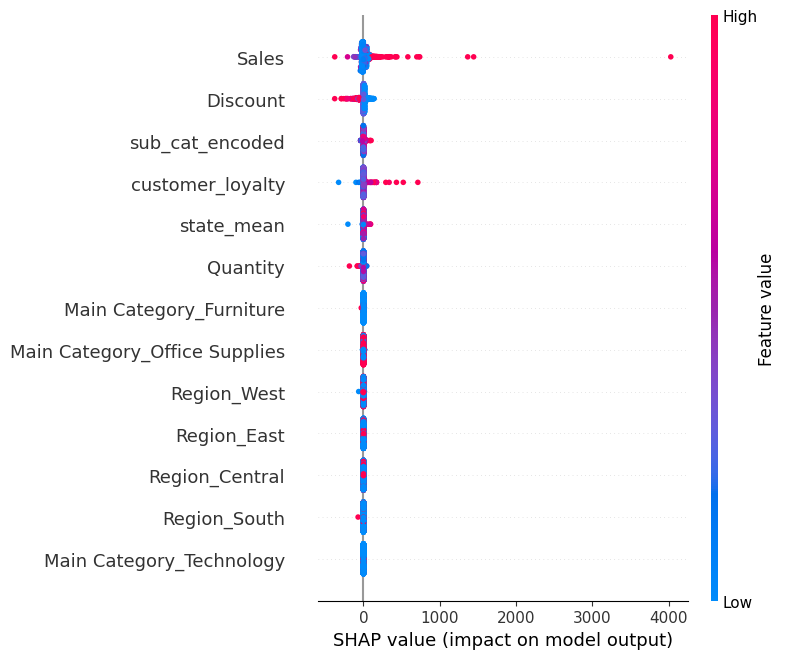

In [86]:
shap.summary_plot(shap_values_profit)

In [76]:
data.groupby("Main Category")["Profit"].mean()

Main Category
Furniture           9.688984
Office Supplies    22.748605
Technology         78.233416
Name: Profit, dtype: float64

In [ ]:
table_dict={k:v.mean() for k,v in zip(shap_values_profit.feature_names,shap_values_profit.values)}

In [61]:
final_df.columns

Index(['Sales', 'Quantity', 'Discount', 'Profit', 'state_mean',
       'customer_loyalty', 'sub_cat_encoded', 'Main Category_Furniture',
       'Main Category_Office Supplies', 'Main Category_Technology',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West'],
      dtype='object')

In [62]:
normalize_feature(final_df)

,Sales,Quantity,Discount,Profit,state_mean,customer_loyalty,sub_cat_encoded,Main Category_Furniture,Main Category_Office Supplies,Main Category_Technology,Region_Central,Region_East,Region_South,Region_West
0,0.008536,0.384615,0.00,0.364204,0.386097,0.427245,0.8125,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.008960,0.384615,0.00,0.369358,0.372660,0.450631,0.6250,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.000990,0.384615,0.25,0.364077,0.272307,0.434304,0.6250,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.002283,0.307692,0.00,0.365109,0.395314,0.431423,0.4375,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.005536,0.153846,0.25,0.362160,0.014739,0.439446,0.5625,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,0.000543,0.307692,0.25,0.363912,0.022551,0.351840,0.1875,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7991,0.001826,0.615385,0.00,0.364794,0.272307,0.451932,0.3750,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7992,0.000900,0.307692,0.00,0.364205,0.386097,0.427710,0.3750,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7993,0.004253,0.461538,0.00,0.365682,0.272307,0.431587,0.3125,1.0,0.0,0.0,0.0,0.0,0.0,1.0


<h3>OPTION 2</h3>

In [63]:
ship_dict=transform_ordinal(data,"Ship Mode","Profit")
final_df["ship_ordinal"]=data["Ship Mode"].map(ship_dict)
main_cat_dict=transform_ordinal(data,"Main Category","Profit")
final_df["main_cat_ordinal"]=data["Main Category"].map(main_cat_dict)
region_dict=transform_ordinal(data,"Region","Profit")
final_df["region_ordinal"]=data["Region"].map(region_dict)


In [64]:
final_df.drop(columns=["Main Category_Furniture","Main Category_Office Supplies","Main Category_Technology","Region_Central",
                       "Region_East","Region_South","Region_West"],inplace=True)

In [65]:
df_norm=normalize_feature(final_df)

In [66]:
X_op2=df_norm.drop(columns=["Profit"])
Y_op2=df_norm["Profit"]

In [67]:
X_train2,X_test2,Y_train2,Y_test2=train_test_split(X_op2,Y_op2,test_size=0.2,random_state=42)

<h3>SHAP Explainer With <b>Option 2</b></h3>

In [138]:
model_profit = RandomForestRegressor()
model_profit.fit(X_train2, Y_train2)

RandomForestRegressor()

In [139]:
explainer_profit = shap.Explainer(model_profit.predict, X_test2)
shap_values_profit = explainer_profit(X_test2)

Exact explainer: 1600it [11:44,  2.24it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


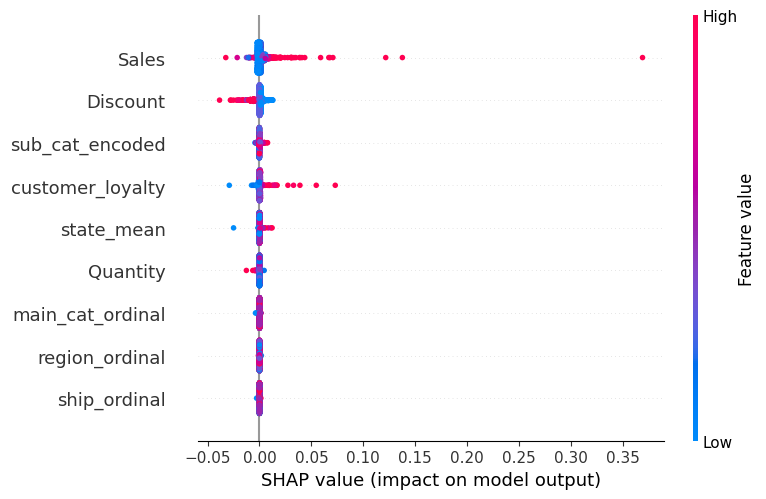

In [140]:
shap.summary_plot(shap_values_profit)

In [142]:
data.to_csv("Final.csv",index=False)

<h3>OPTION 2 Score

In [73]:
rf2 = RandomForestRegressor(n_estimators=95, random_state=42)

# Train the model using the training data
rf2.fit(X_train2, Y_train2)

# Make predictions on the testing data
y_pred2 = rf2.predict(X_test2)

# Calculate R^2 score and Mean Squared Error (MSE) for the model
r2_op2 = r2_score(Y_test2, y_pred2)
mse_op2 = mean_squared_error(Y_test2, y_pred2)

print("R^2 Score: ", r2_op2)
print("Mean Squared Error (MSE): ", mse_op2)

R^2 Score:  0.932073781627988
Mean Squared Error (MSE):  2.2278166665812145e-05


<h3>Polynomial Order For <b>OPTION 2<b></h3>

In [74]:
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define the hyperparameters to search over
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4]}  # Try different polynomial degrees

# Use GridSearchCV to find the best polynomial order
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)  # 5-fold cross-validation
grid.fit(X_train2, Y_train2)

# Get the best polynomial order
best_polynomial_order = grid.best_params_['polynomialfeatures__degree']

In [76]:
best_pipeline = make_pipeline(PolynomialFeatures(degree=best_polynomial_order), LinearRegression())

best_pipeline.fit(X_train2, Y_train2)

# Predict the target values
y_pred2 = best_pipeline.predict(X_test2)

# Calculate the R-squared score
r2poly_2 = r2_score(Y_test2, y_pred2)

# Print the best polynomial order and the R-squared score
print("Best Polynomial Order:", best_polynomial_order)
print("R-squared Score:", r2poly_2)

Best Polynomial Order: 2
R-squared Score: 0.8364378638200528


<h3>Option: 3 One Hot Encode Main Category and state and drop "State mean"" </h3>

In [77]:
final_df_op3=data.drop(columns=["Ship Mode","Customer Name","State","Product ID","Region","Main Category","Sub Category","state_mean"])
final_df_op3.head()

,Sales,Quantity,Discount,Profit,Order year,Order quarter,customer_loyalty,ship_priority,sub_cat_encoded
0,119.940,6,0.0,5.9970,2017,4,-2.023000,0,13
1,125.880,6,0.0,60.4224,2017,3,35.348275,2,10
2,14.304,6,0.2,4.6488,2014,3,9.258253,2,10
3,32.400,5,0.0,15.5520,2017,2,4.654125,2,7
4,77.952,3,0.2,-15.5904,2017,4,17.475229,2,9


In [78]:
final_df_op3=pd.concat([final_df_op3,one_hot_encode_columns(["State","Main Category","Region"],data)],axis=1)
final_df_op3


,Sales,Quantity,Discount,Profit,Order year,Order quarter,customer_loyalty,ship_priority,sub_cat_encoded,State_Alabama,...,State_West Virginia,State_Wisconsin,State_Wyoming,Main Category_Furniture,Main Category_Office Supplies,Main Category_Technology,Region_Central,Region_East,Region_South,Region_West
0,119.940,6,0.0,5.9970,2017,4,-2.023000,0,13,0,...,0,0,0,0,0,1,0,1,0,0
1,125.880,6,0.0,60.4224,2017,3,35.348275,2,10,0,...,0,0,0,0,1,0,1,0,0,0
2,14.304,6,0.2,4.6488,2014,3,9.258253,2,10,0,...,0,0,0,0,1,0,0,0,0,1
3,32.400,5,0.0,15.5520,2017,2,4.654125,2,7,0,...,0,0,0,0,1,0,0,0,1,0
4,77.952,3,0.2,-15.5904,2017,4,17.475229,2,9,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,8.040,5,0.2,2.9145,2015,2,-122.522389,3,3,0,...,0,0,0,0,1,0,0,1,0,0
7991,26.010,9,0.0,12.2247,2016,1,37.428837,3,6,0,...,0,0,0,0,1,0,0,0,0,1
7992,13.050,5,0.0,6.0030,2015,2,-1.279672,2,6,0,...,0,0,0,0,1,0,0,1,0,0
7993,59.990,7,0.0,21.5964,2016,1,4.916386,2,5,0,...,0,0,0,1,0,0,0,0,0,1


In [79]:
final_df_op3=normalize_feature(final_df_op3)
X_opt3=final_df_op3.drop(columns=["Profit"])
Y_opt3=final_df_op3["Profit"]
X_train3,X_test3,Y_train3,Y_test3=train_test_split(X_opt3,Y_opt3,test_size=0.2,random_state=42)

In [80]:
rf_3 = RandomForestRegressor(n_estimators=90, random_state=42)

# Train the model using the training data
rf_3.fit(X_train3, Y_train3)

# Make predictions on the testing data
y_pred3 = rf_3.predict(X_test3)

# Calculate R^2 score and Mean Squared Error (MSE) for the model
r2_op3 = r2_score(Y_test3, y_pred3)
mse_op3 = mean_squared_error(Y_test3, y_pred3)

print("R^2 Score: ", r2_op3)
print("Mean Squared Error (MSE): ", mse_op3)

R^2 Score:  0.9157537662918168
Mean Squared Error (MSE):  2.763073935956366e-05


<h3>Worst than the other options as shown above<h3>

<h3>Option 4

In [81]:
final_df_op4=data.drop(columns=["Ship Mode","Customer Name","State","Product ID","Region","Main Category","Sub Category"])
final_df_op4["main_cat_means"]=data["Main Category"].map(transform_ordinal(data,"Main Category","Profit"))      #No Difference between transform ordinal and transform ordinal means
final_df_op4=normalize_feature(final_df_op4)
X_opt4=final_df_op4.drop(columns=["Profit"])
Y_opt4=final_df_op4["Profit"]
X_train4,X_test4,Y_train4,Y_test4=train_test_split(X_opt4,Y_opt4,test_size=0.2,random_state=42)

In [82]:
X_train4

,Sales,Quantity,Discount,Order year,Order quarter,state_mean,customer_loyalty,ship_priority,sub_cat_encoded,main_cat_means
1467,0.006994,0.153846,0.250,0.333333,1.000000,0.411266,0.446212,0.000000,0.6250,0.5
6071,0.014837,0.000000,0.000,0.000000,0.333333,0.386097,0.480597,0.666667,0.6875,0.5
2337,0.028944,0.230769,0.000,0.000000,1.000000,0.272307,0.426901,0.666667,0.5625,0.5
1578,0.002824,0.076923,0.000,1.000000,0.666667,0.606755,0.438091,0.666667,0.3125,0.0
6522,0.003165,0.307692,0.000,1.000000,1.000000,0.285908,0.432121,0.666667,0.4375,0.5
...,...,...,...,...,...,...,...,...,...,...
5226,0.002917,0.384615,0.250,1.000000,1.000000,0.386097,0.433068,1.000000,0.6250,0.5
5390,0.005565,0.307692,0.000,0.000000,0.666667,0.272307,0.432988,0.666667,0.5000,0.5
860,0.005717,0.000000,0.000,1.000000,0.666667,0.521724,0.438593,0.666667,0.6875,0.5
7603,0.003223,0.076923,0.250,0.666667,1.000000,0.108628,0.433911,0.666667,0.3125,0.0


<h3>SHAP explainer for option 4</h3>

In [84]:
model_profit = RandomForestRegressor()
model_profit.fit(X_train4, Y_train4)
explainer_profit = shap.Explainer(model_profit.predict, X_test4)
shap_values_profit = explainer_profit(X_test4)

Exact explainer: 1600it [25:24,  1.05it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


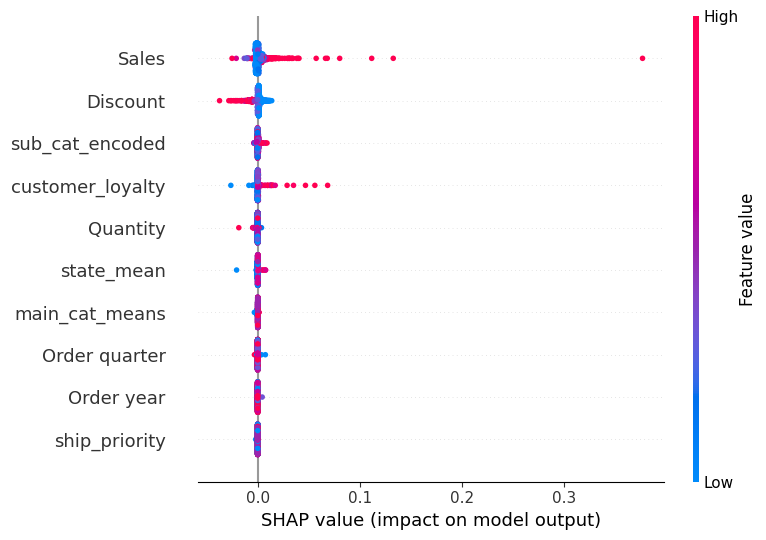

In [85]:
shap.summary_plot(shap_values_profit)

In [87]:
rf_4 = RandomForestRegressor(n_estimators=90, random_state=42)

# Train the model using the training data
rf_4.fit(X_train4, Y_train4)

# Make predictions on the testing data
y_pred4 = rf_4.predict(X_test4)

# Calculate R^2 score and Mean Squared Error (MSE) for the model
r2_op4 = r2_score(Y_test4, y_pred4)
mse_op4 = mean_squared_error(Y_test4, y_pred4)

print("R^2 Score: ", r2_op4)
print("Mean Squared Error (MSE): ", mse_op4)

R^2 Score:  0.9240393965554043
Mean Squared Error (MSE):  2.4913251821356228e-05


<h3>Compare between the 4 options </h3>

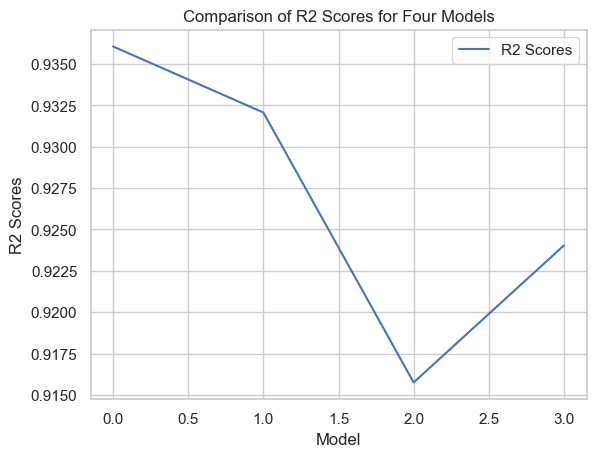

In [193]:
models={"Model":["Option1","Option2","Option3","Option4"],
        "R2 Scores":[r2_op1,r2_op2,r2_op3,r2_op4],
        "Mse":[mse_op1,mse_op2,mse_op3,mse_op4]}
df = pd.DataFrame(models)

sns.set(style="whitegrid")

# Create a bar plot using Seaborn
sns.barplot(data=df[['R2 Scores']])

# Set the title and labels for the plot
plt.title("Comparison of R2 Scores for Four Models")
plt.xlabel("Model")
plt.ylabel("R2 Scores")

# Show the plot
plt.show()